In [1]:
import os
import sys
os.chdir('/home/msun415/induction/')
import pickle
from src.config import METHOD, DATASET, GRAMMAR
import importlib
from src.examples import *
from src.draw.color import to_hex, CMAP
from src.draw.graph import draw_graph
from src.config import RADIUS
from argparse import ArgumentParser
import pickle
from src.grammar.common import get_args
from src.grammar.ednce import *
from src.draw.graph import *
from src.api.get_motifs import *
from src.algo.utils import *
from src.algo.common import *
from src.grammar.common import *
from src.grammar.utils import *
from src.algo.ednce import terminate, dfs
from src.model import graph_regression, transformer_regression
from argparse import ArgumentParser
from networkx.algorithms.isomorphism import DiGraphMatcher
import pdb
from datetime import datetime

/home/msun415/miniconda3/envs/ckt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


51 245
51 245


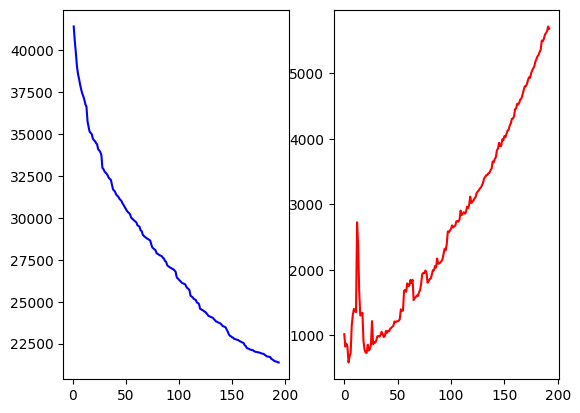

In [17]:
%matplotlib inline

def match(timestamp):
    pattern = r"(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})"
    match = re.match(pattern, timestamp)
    if match:
        year, month, day, hour, minute, second = map(int, match.groups())
        dt = datetime(year, month, day, hour, minute, second)
    else:
        print("No match found!")    
        return None
    return dt


def plot_run(last_run, ax, plot_time=False, **kwargs):
    lines = open('/home/msun415/induction/data/api_ckt_ednce.log').readlines()
    occurs = re.findall('(.+)graph at iter (\d+) has (\d+) nodes', '\n'.join(lines))
    start_inds = [i for i in range(len(occurs)) if occurs[i][1] == '1']    
    index_start = start_inds[-last_run]
    index_end = start_inds[-(last_run-1)] if last_run > 1 else len(occurs)
    inds = []
    vals = []
    dts = []
    print(index_start, index_end)
    for i in range(index_start, index_end):
        i1 = occurs[i][0].index('[')
        i2 = occurs[i][0].index(']')
        dt_cur = match(occurs[i][0][i1+1:i2])
        if i > index_start:
            dt_diff = (dt_cur-dt)
            dts.append(dt_diff.seconds)
        dt = dt_cur
        inds.append(int(occurs[i][1]))
        vals.append(int(occurs[i][2]))
    if plot_time:
        ax.plot(range(len(dts)), dts, **kwargs)
    else:
        ax.plot(inds, vals, **kwargs)
    

plt.close('all')
fig, axes = plt.subplots(1, 2)
plot_run(1, axes[0], c='blue')
plot_run(1, axes[1], plot_time=True, c='red')
fig.show()